In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import os
import glob
import cv2
import functools
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras import layers, losses, models
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
INPUT_PATH = 'G:/data/Carvana Image Masking Challenge/carvana-image-masking-challenge/'
DATA_PATH = INPUT_PATH
TRAIN_DATA = os.path.join(DATA_PATH, "train")
TRAIN_MASKS_DATA = os.path.join(DATA_PATH, "train_masks")
TEST_DATA = os.path.join(DATA_PATH, "test")
TRAIN_MASKS_CSV_FILEPATH = os.path.join(DATA_PATH, "train_masks.csv")
METADATA_CSV_FILEPATH = os.path.join(DATA_PATH, "metadata.csv")

TRAIN_MASKS_CSV = pd.read_csv(TRAIN_MASKS_CSV_FILEPATH)
METADATA_CSV = pd.read_csv(METADATA_CSV_FILEPATH)

In [3]:
img_dir = os.path.join(DATA_PATH, "train")
label_dir = os.path.join(DATA_PATH, "train_masks")

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [4]:
# Split data in train and test set
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [5]:
def get_image_matrix(image_path):    
    img = Image.open(image_path)
    return np.asarray(img, dtype=np.uint8)

Image shape: (1280, 1918, 3) | image type: uint8 | mask shape: (1280, 1918) | mask type: uint8


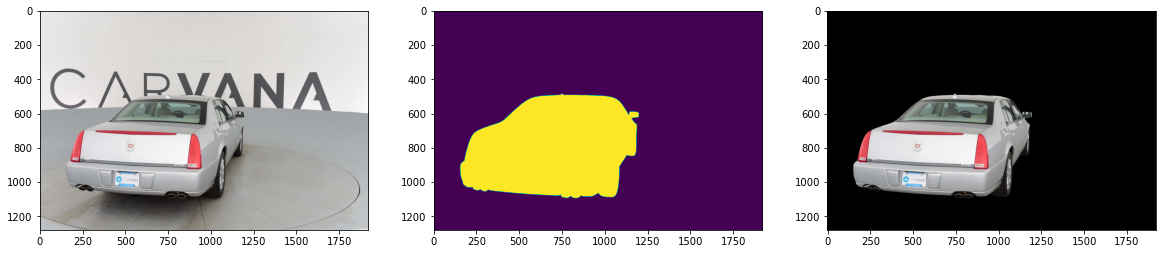

In [6]:
image_id = 118

plt.figure(figsize=(20, 20))
img = get_image_matrix(x_train_filenames[image_id])
mask = get_image_matrix(y_train_filenames[image_id])
img_masked = cv2.bitwise_and(img, img, mask=mask)

print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}"
      .format(img.shape, img.dtype, mask.shape, mask.dtype) )

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(img_masked);

In [7]:
TRAIN_LENGTH = len(x_train_filenames)
img_shape = (224, 224, 3)
batch_size = 8
epochs = 20
OUTPUT_CHANNELS = 3
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size

In [8]:
def _process_pathnames(fname, label_path):
    # Мы отображаем эту функцию для каждой пары путей
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    # gif изображения возвращаются как (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    # Изображение метки должно иметь значения только 1 или 0, что указывает на пиксель
    # объекта (автомобиля) или нет (фона). Мы берем только первый канал.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """Этот fn будет выполнять горизонтальное или вертикальное смещение"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([], 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])

        output_img = tfa.image.transform(output_img,
                                             [width_shift_range, height_shift_range])
        label_img = tfa.image.transform(label_img,
                                             [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                    lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Измените размер изображения до некоторого размера, например [512, 512]
             scale=1,  # Масштабное изображение, например 1/255.
             hue_delta=0,  # Регулирование оттенка изображения RGB по случайному коэффициенту
             horizontal_flip=False,  # Рандом левого или правого flip,
             width_shift_range=0,  # Случайно сдвиг изображения по горизонтали
             height_shift_range=0):  # Случайно сдвинуть изображение по вертикали
    if resize is not None:
        # Изменить размер изображений (gif b jpg)
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    #img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, tf.float32) * scale
    img = tf.cast(img, tf.float32) * scale 
    return img, label_img

In [13]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Создать набор данных из пути файлов и лейбов
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    #Сопоставьте нашу функцию предварительной обработки с каждым элементом в нашем наборе данных, 
    #используя преимущества многопоточности
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)


    # It's necessary to repeat our data for all epochs 
    dataset = dataset.cache().batch(batch_size).repeat()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [16]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [17]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [18]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

In [20]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [21]:
for image, mask in train_ds.take(1):
  sample_image, sample_mask = image, mask

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape = img_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [23]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [24]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=img_shape)
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [29]:
val_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

In [30]:
VALIDATION_STEPS = 11

model_history = model.fit(train_ds, epochs=epochs,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds)

Train for 508 steps, validate for 11 steps
Epoch 1/20
508/508 [==============================] - 57s 111ms/step - loss: 0.0565 - accuracy: 0.9771 - val_loss: 0.0867 - val_accuracy: 0.9672
Epoch 2/20
508/508 [==============================] - 28s 55ms/step - loss: 0.0170 - accuracy: 0.9925 - val_loss: 0.0418 - val_accuracy: 0.9832
Epoch 3/20
508/508 [==============================] - 28s 54ms/step - loss: 0.0141 - accuracy: 0.9935 - val_loss: 0.0402 - val_accuracy: 0.9842
Epoch 4/20
508/508 [==============================] - 28s 55ms/step - loss: 0.0125 - accuracy: 0.9941 - val_loss: 0.0513 - val_accuracy: 0.9807
Epoch 5/20
508/508 [==============================] - 28s 54ms/step - loss: 0.0114 - accuracy: 0.9945 - val_loss: 0.0507 - val_accuracy: 0.9818
Epoch 6/20
508/508 [==============================] - 28s 54ms/step - loss: 0.0105 - accuracy: 0.9948 - val_loss: 0.0463 - val_accuracy: 0.9837
Epoch 7/20
508/508 [==============================] - 28s 54ms/step - loss: 0.0097 - accurac

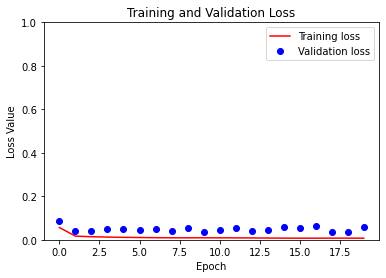

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

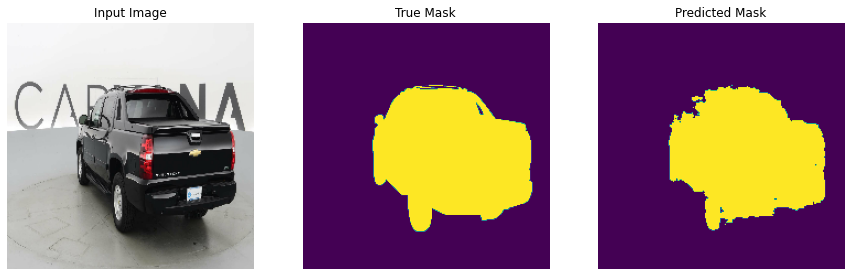

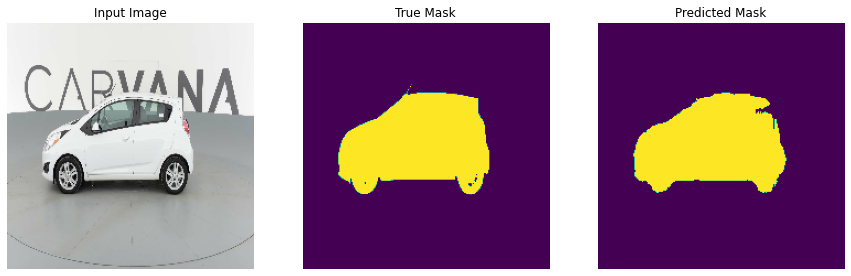

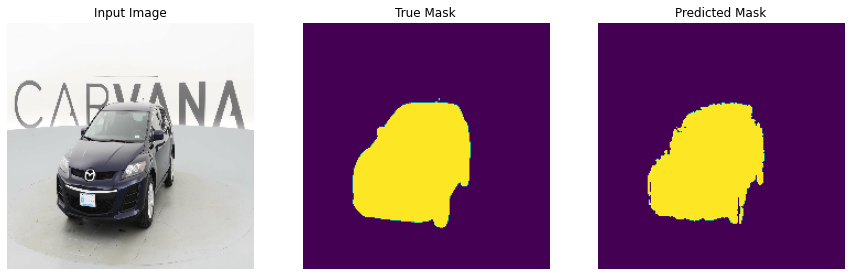

In [32]:
show_predictions(val_ds, 3)